In [221]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
%reset -f #for clearing workspace

Don't know how to reset  #for, please run `%reset?` for details
Don't know how to reset  clearing, please run `%reset?` for details
Don't know how to reset  workspace, please run `%reset?` for details


In [222]:
#Load data
file_path = os.path.join("C://Users/alexh/OneDrive/Documents/My Documents/Postdoc/Python/DR and clustering sandbox", "Dow dataset (anonymised).xlsx")
train_data = pd.read_excel(file_path, sheet_name="TrainingData")
test_data = pd.read_excel(file_path, sheet_name="TestData")

c:\ProgramData\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Dataset description

"The case is based on data from a real industrial application at Dow Chemical.

"The data set includes 57 measurements of process variables, which are potentially related to the composition. However, not all of them are highly correlated to the output. The data file includes two worksheets with training and test data. The input columns are named x1 to x57 and the output column is named as y. The training worksheet includes 747 training data points and the test data sheet includes 319 test data points."

Link: https://web.archive.org/web/20120628140646/http://casnew.iti.upv.es/index.php/evocompetitions/105-symregcompetition 

**Aim**: develop a model capable of accurately forecasting the composition 7 time units in advance.

In [223]:
# Check missing values - training data
missingness = train_data.isna().sum()/len(train_data)
print("Missing values (% of total)\n",100*missingness)

Missing values (% of total)
 x1     0.0
x2     0.0
x3     0.0
x4     0.0
x5     0.0
x6     0.0
x7     0.0
x8     0.0
x9     0.0
x10    0.0
x11    0.0
x12    0.0
x13    0.0
x14    0.0
x15    0.0
x16    0.0
x17    0.0
x18    0.0
x19    0.0
x20    0.0
x21    0.0
x22    0.0
x23    0.0
x24    0.0
x25    0.0
x26    0.0
x27    0.0
x28    0.0
x29    0.0
x30    0.0
x31    0.0
x32    0.0
x33    0.0
x34    0.0
x35    0.0
x36    0.0
x37    0.0
x38    0.0
x39    0.0
x40    0.0
x41    0.0
x42    0.0
x43    0.0
x44    0.0
x45    0.0
x46    0.0
x47    0.0
x48    0.0
x49    0.0
x50    0.0
x51    0.0
x52    0.0
x53    0.0
x54    0.0
x55    0.0
x56    0.0
x57    0.0
y      0.0
dtype: float64


In [224]:
# Check missing values - test data
missingness = test_data.isna().sum()/len(test_data)
print("Missing values (% of total)\n",100*missingness)

#No data are missing in either the training or test sets. Therefore, no data imputation is required.

Missing values (% of total)
 x1     0.0
x2     0.0
x3     0.0
x4     0.0
x5     0.0
x6     0.0
x7     0.0
x8     0.0
x9     0.0
x10    0.0
x11    0.0
x12    0.0
x13    0.0
x14    0.0
x15    0.0
x16    0.0
x17    0.0
x18    0.0
x19    0.0
x20    0.0
x21    0.0
x22    0.0
x23    0.0
x24    0.0
x25    0.0
x26    0.0
x27    0.0
x28    0.0
x29    0.0
x30    0.0
x31    0.0
x32    0.0
x33    0.0
x34    0.0
x35    0.0
x36    0.0
x37    0.0
x38    0.0
x39    0.0
x40    0.0
x41    0.0
x42    0.0
x43    0.0
x44    0.0
x45    0.0
x46    0.0
x47    0.0
x48    0.0
x49    0.0
x50    0.0
x51    0.0
x52    0.0
x53    0.0
x54    0.0
x55    0.0
x56    0.0
x57    0.0
y      0.0
dtype: float64


Very little is known about the dataset. They don't even provide a timestamp! Plot against index to determine whether the data is temporally continuous (i.e., whether the measurements are consecutive)

In [225]:

train_ind = np.linspace(0,len(train_data)-1,len(train_data))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(train_ind,train_data.iloc[:,1],marker = 'o',markersize=2)
ax.set_xlabel("Index")
ax.set_ylabel("x2")

Text(0, 0.5, 'x2')

There is clear evidence of temporal continuity in these data. Therefore, the dataset can be viewed as a time series. 
Therefore, this dataset lends itself to time series forecasting.

As no information regarding sampling frequency (nor any process knowledge) is available, the sampling rate is kept as is. 
Moreover, the lack of process knowledge arguably renders any preprocessing (smoothing, outlier removal) unwise.

**Aim: develop a model to forecast the time-series data for the measurement of interest (y)**

In [226]:
# Check Pearson/Spearman correlation coefficient
corr = train_data.corr(method='spearman')
# Round numbers to 2 decimal places, to make it easier to read
corr = corr.apply(lambda x: round(x,1)) #lambda defines an anonymous function
# Generate a mask for the upper triangle (i.e. to remove upper triangle and keep view simple)
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask, square=True,cmap=plt.cm.bwr,annot=True,vmin=-1,vmax=1)
plt.title('Spearman Correlation Coefficient')
plt.tight_layout()

# Based on this plot, we can already eliminate some highly positively/negatively correlated features.
# These are as follows:
# x1 with (x7, x38)/x38 with x7
# x17 with (x18, x19)
# x27 with x28
# x52 with x53
# x33 with (x52, x53)
# x37 with x35
# x24 with x23
# x16 with (x17, x18, x19, x20)
# x53 with x51
# x54 with x55
# x54 with (x18, x19, x20)
# x47 with x31
# x57 with x56
# x42 with x45
# x18 with (x19,x20)
# x20 with x19
# x46 with x40
# x26 with x28
# x21 with x22
# x14 with x15
# x7 with x10

In [227]:
# From each pair of strongly correlated features, delete one
retained_features = train_data.columns.drop(["x1","x38","x17","x27","x52","x33","x37","x24","x16","x53","x54","x47","x57","x42","x18","x20","x46","x26","x21","x14","x7"])
train_data = train_data[retained_features]
test_data = test_data[retained_features]

Correlation coefficients up to ca +/- 0.7 between input variables are accepted.


Tree-based ensemble methods tend to deal well with high dimensionality, and highly correlated feature spaces. 
However, removing highly correlated variables yields a simpler model, and may still translate to improved accuracy. There's no harm in removing redundancy! 
Doing so may also reduce the training time for hyperparameter optimisation.

Check Pearson/Spearman correlation coefficient again

In [228]:
corr = train_data.corr(method='spearman')
# Round numbers to 2 decimal places, to make it easier to read
corr = corr.apply(lambda x: round(x,1)) #lambda defines an anonymous function
# Generate a mask for the upper triangle (i.e. to remove upper triangle and keep view simple)
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask, square=True,cmap=plt.cm.bwr,annot=True,vmin=-1,vmax=1)
plt.title('Spearman Correlation Coefficient')
plt.tight_layout()

Comments on deleting some of the features with a very low correlation coefficient with the target feature (y)

Note that Pearson's correlation coefficient would only look for linear correlation. Therefore, it would be ill-advised to remove features with very weak correlation with the target feature based on Pearson correlation. 

But what about Spearman's rank correlation coefficient?
Spearman's correlation coefficient requires the assumption of a monotonic relationship between features (i.e., the one a consistent increasing/decreasing relationship). Therefore, small Spearman's correlation coefficients cannot rule out meaningful non-monotonic relationships between the target and the input features. 
NOTE: I tried this nonetheless - it did not reduce the backtesting error for the test data.

In [229]:
## Remove features with low correlation to target feature
# retained_features = train_data.columns.drop(["x4","x11","x23","x39","x48","x51","x55"])
# train_data = train_data[retained_features]
# test_data = test_data[retained_features]

Check: does the test data have a very different set of correlation coefficients?
This would indicate a notable difference between the training & test datasets.

In [230]:
corr = test_data.corr(method='spearman')
# Round numbers to 2 decimal places, to make it easier to read
corr = corr.apply(lambda x: round(x,1)) #lambda defines an anonymous function
# Generate a mask for the upper triangle (i.e. to remove upper triangle and keep view simple)
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask, square=True,cmap=plt.cm.bwr,annot=True,vmin=-1,vmax=1)
plt.title('Spearman Correlation Coefficient')
plt.tight_layout()

#Only considering the final row, results seem quite similar.

Visualise time series data (training)

In [231]:
fig,ax  = plt.subplots(train_data.shape[1],1,sharex = True,figsize = (20,20))

#Smooth data - a previous attempt at this forecasting problem suggests that the data requires some noise removal.
# Each window considers a point and n_steps-1 points to its left.
n_steps = 5
train_data = train_data.rolling(window = n_steps).mean()
# Extrapolate data at start of dataframe that is rendered missing by the smoothing operation
train_data = train_data = train_data.bfill()#

for idx in range(train_data.shape[1]):
    ax[idx].plot(train_data.index,train_data.iloc[:,idx],label = train_data.columns[idx],marker = 'o',markersize=2)
    ax[idx].legend(loc = "right") 
    ax[idx].set_xlabel("Index")

# Many of the measurements appear unavailable for prolonged periods, as evidenced by long periods in which they remain stationary.

Visualise time series data (test)

In [232]:
fig,ax  = plt.subplots(test_data.shape[1],1,sharex = True,figsize = (20,20))

#  apply smoothing to test data. 
test_data = test_data.rolling(window = n_steps).mean()
# Extrapolate data at start of dataframe that is rendered missing by the smoothing operation
test_data = test_data.bfill()#

for idx in range(test_data.shape[1]):
    ax[idx].plot(test_data.index,test_data.iloc[:,idx],label = test_data.columns[idx],marker = 'o',markersize=2)
    ax[idx].legend(loc = "right") 
    ax[idx].set_xlabel("Index")

Check: what effect does smoothing have on correlation coefficients?

In [233]:
corr = test_data.corr(method='spearman')
# Round numbers to 2 decimal places, to make it easier to read
corr = corr.apply(lambda x: round(x,1)) #lambda defines an anonymous function

corr.iloc[-1,:]

x2     0.2
x3    -0.0
x4    -0.2
x5    -0.1
x6    -0.5
x8     0.4
x9     0.1
x10    0.1
x11   -0.0
x12   -0.2
x13   -0.1
x15   -0.3
x19   -0.1
x22    0.1
x23    0.1
x25    0.2
x28    0.4
x29    0.0
x30    0.1
x31    0.3
x32    0.3
x34    0.4
x35   -0.4
x36    0.1
x39   -0.0
x40    0.2
x41   -0.1
x43    0.1
x44    0.4
x45    0.1
x48   -0.1
x49    0.7
x50   -0.1
x51   -0.1
x55    0.1
x56   -0.1
y      1.0
Name: y, dtype: float64

Combine training & test sets and format appropriately.

In [234]:
# NOTE: we assume that test data follows on from training data.
combined_data = pd.concat([train_data,test_data]) 
#create arbitrary DateTimeIndex (with a frequency) and add to data. This is required by skforecast.
dti = pd.date_range("2018-01-01", periods=len(combined_data), freq="h") 
combined_data.index = dti 
combined_data.index.name = 'idx'
# NOTE: a timestamp also helps to ensure that predictions and test data can be aligned appropriately.
# Data not scaled, as I believe that isn't necessary for a LightGBM model.

# Create train & test sets with DateTimeIndices.
train_data = combined_data.loc[combined_data.index < "2018-02-01 03:00:00",:]
test_data = combined_data.loc[combined_data.index >= "2018-02-01 03:00:00",:]

Train an ensemble model (LightGBM) to forecast the target feature, y

LightGBM has been tremendously succcessful in time series forecasting competitions outside of the realm of process engineering. Both LightGMB and XGBoost are my go-to models for time series forecasting. 

In [235]:
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skforecast.direct import ForecasterDirectMultiVariate 
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster_multiseries

steps = 7 #desired number of steps to be forecasted.
forecaster = ForecasterDirectMultiVariate(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 level           = 'y',
                 steps           = steps,
                 lags             = 7,
                 window_features = None)
# NOTE: ForecasterDirectMultiVariate fits one model per step. 7 steps = 7 models.

# Determine optimal hyperparameters using time-series fold cross-validation on the training dataset.
gridsearch_steps = steps #this cannot be smaller than the steps parameter
cv_grid_search = TimeSeriesFold(
         gap                    = 0, #this is the gap in timestamps between the training & test data
         steps                 = gridsearch_steps,
         initial_train_size    = np.round(np.divide(len(train_data),gridsearch_steps),0).astype(int),# initial fold size determined by gridsearch_steps
         refit                 = False,
         allow_incomplete_fold = True
     )

embeddings_grid = {
    'embeddings_1': [1],
    # 'embeddings_2' : [1,2,3]
    # 'embeddings_3': 4,# lags 1 - 4
    # 'embeddings_4': 7, # lags 1 - 7
    # 'lags_6': [1, 7, 14, 21] 
    } #NOTE: choosing lags & embeddings using methods from dynamic embedding is promising, but it leads to a large reduction in the size of the dataset.
 

param_grid = {
    'max_depth': [3,5,10],# [5, 10 , 15]
    'num_leaves': [2,5,10]#[10,20,30,40]
}# The nice thing about tree-based ensmeble methods is that they tend to be relatively robust to the choice of hyperparameters. 

results = grid_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = train_data,
              param_grid          = param_grid,
              lags_grid           = embeddings_grid,
              cv                  = cv_grid_search,
              levels               = 'y',
              metric              = 'mean_absolute_error',
          )

# forecaster automatically fitted with the best hyperparameters.
# Note the "backtesting metric" is determined from the dataset using the specified TimeSeriesFold object "cv_grid_search".

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'max_depth': 3, 'num_leaves': 2}
  Backtesting metric: 0.1834144486334131
  Levels: ['y']



Perform backtesting to validate the forecasting model

Visual illustration of backtesting without refit: 

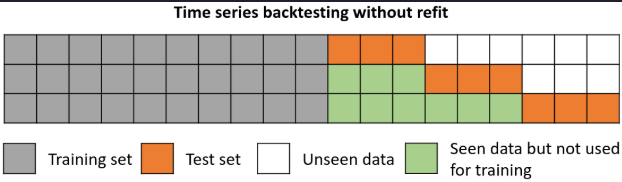

Taken from the skforecast website (https://skforecast.org/0.16.0/user_guides/backtesting)

The data are trained on an training dataset. Then, the model's performance in forecasting _n_ steps ahead is tested. Subsequently, the model's performance is tested for the next _n_ steps, and so no.
For each set of _n_ steps the model forecasts, the model's inputs move _n_ steps forwards. While these new _n_ steps are seen by the model, the model is not retrained each time another forecast is made.

Fit forecaster model to training data using hyperparameters determined above. Then, use backtesting to test model on unseen (test) data.

In [236]:
cv_backtesting = TimeSeriesFold(
         steps                 = steps,
         initial_train_size    = len(train_data),
         refit                 = False,
         allow_incomplete_fold = True
     )

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster = forecaster,
                                           series     = combined_data,
                                           cv         = cv_backtesting,
                                           metric     = 'mean_absolute_error'
                                       )

mae = pd.to_numeric(metrics_levels.iloc[0,1])
print("The mean absolute error is %.2f" % mae)

  0%|          | 0/46 [00:00<?, ?it/s]

The mean absolute error is 0.15


Plot the forecasts and the corresponding data on a time series plot

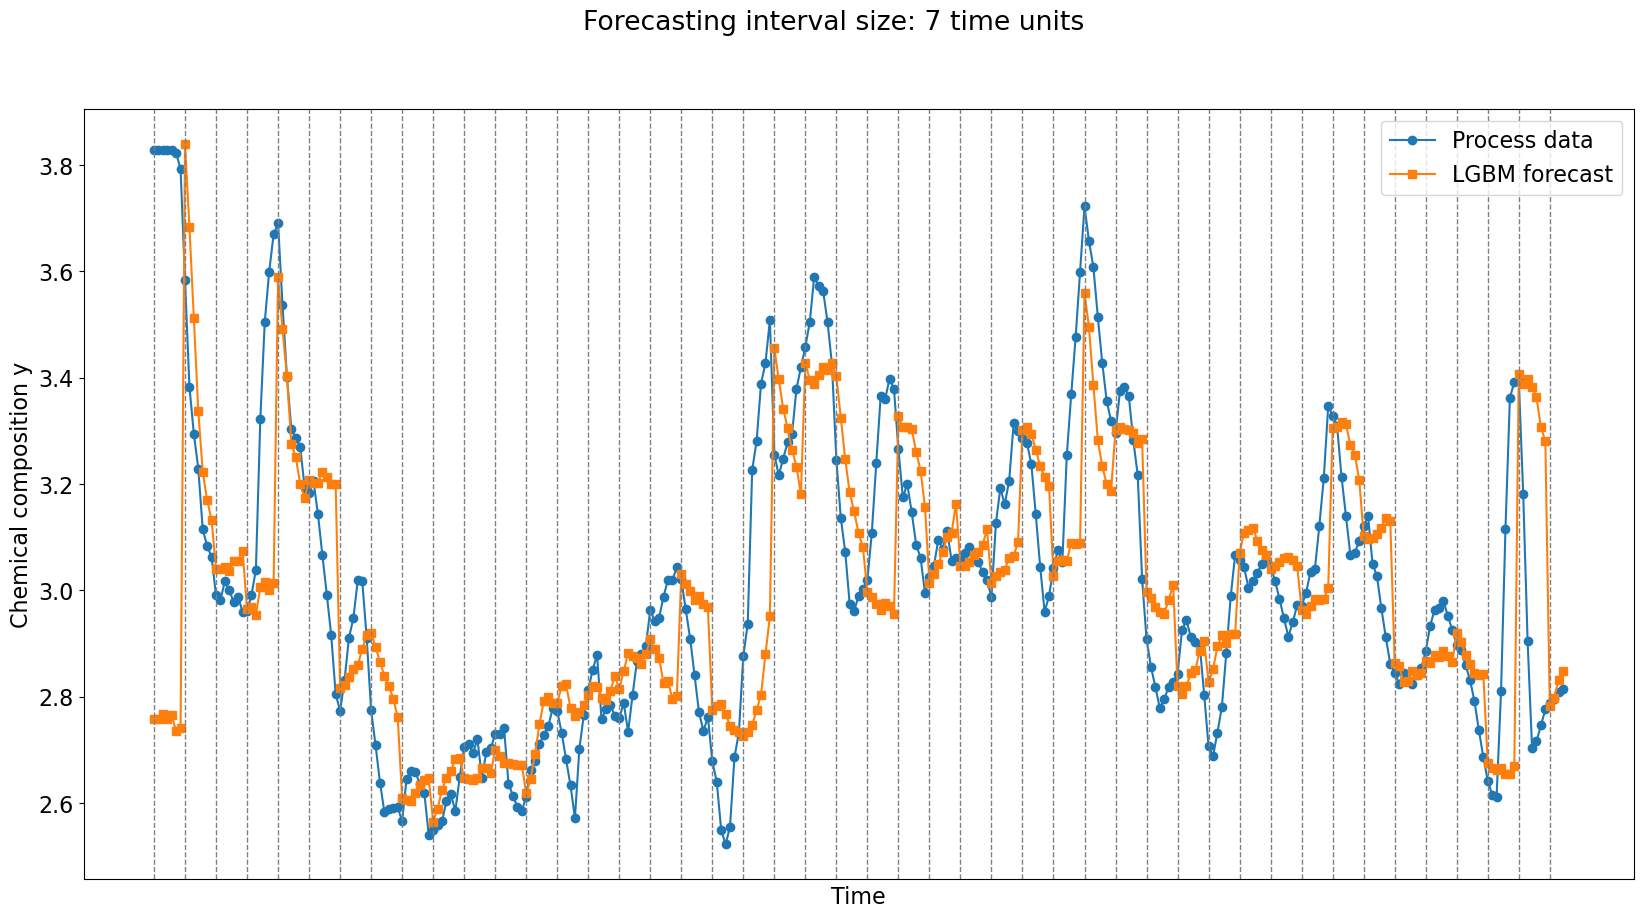

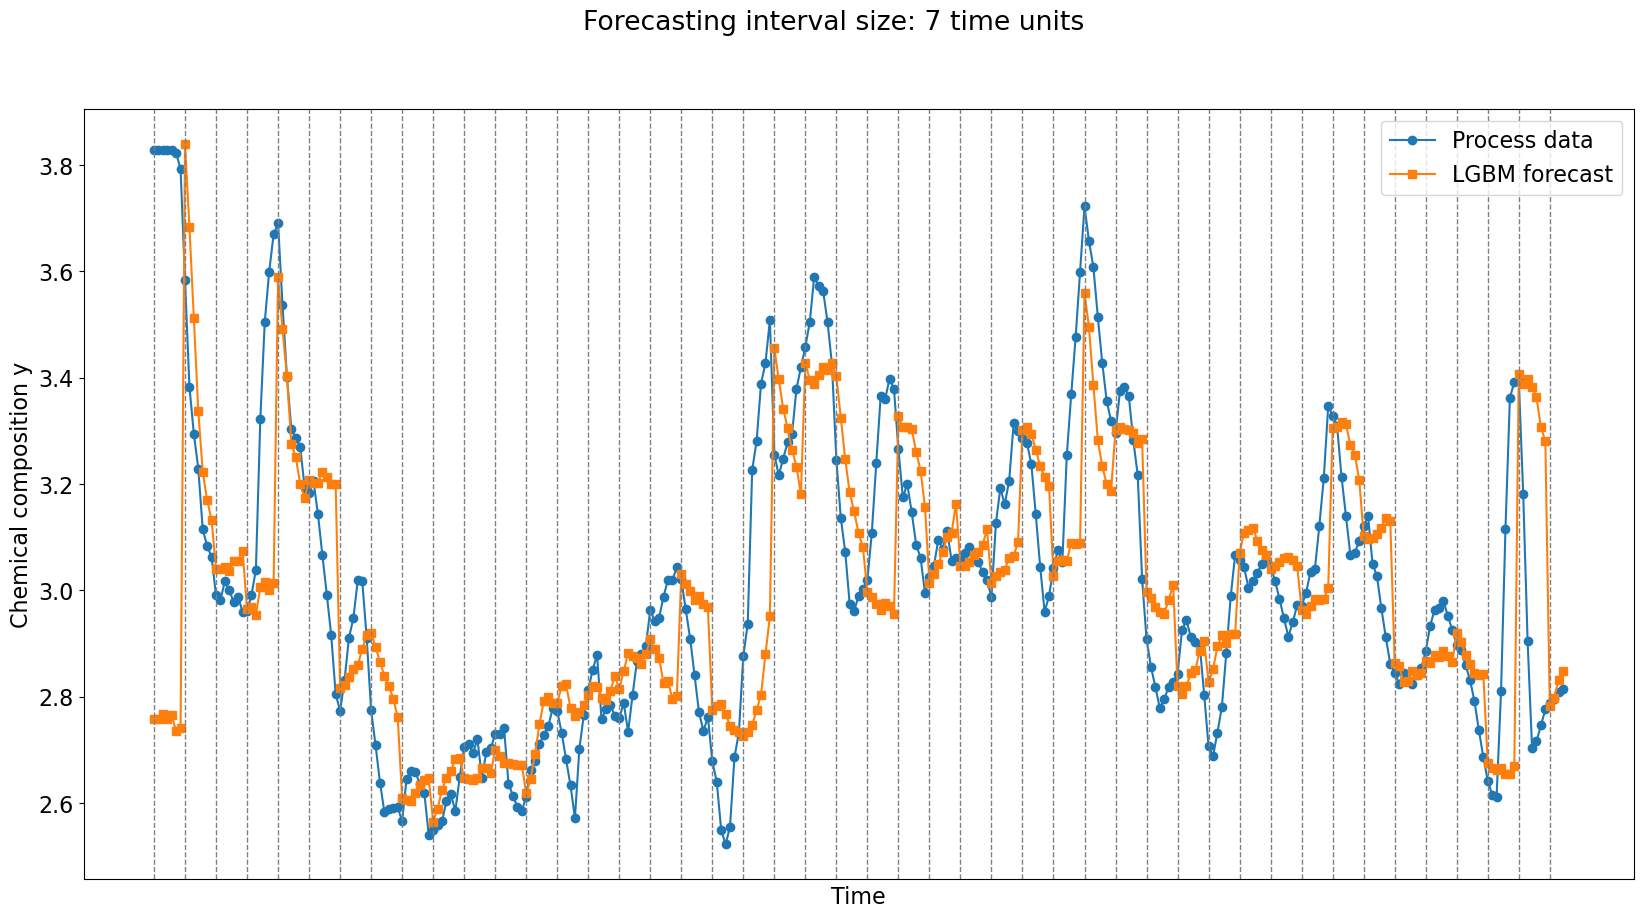

In [239]:
fig,ax  = plt.subplots(figsize = (20,10))
ax.plot(combined_data.loc[combined_data.index >= "2018-02-01 03:00:00","y"],marker = 'o',label = "Process data")
ax.plot(backtest_predictions.index,backtest_predictions['pred'],marker = 's',label = "LGBM forecast")
fig.suptitle(f'Forecasting interval size: {steps} time units')

for i  in (np.arange(0,len(test_data),step=steps)):# Show forecasting intervals
    ax.axvline(test_data.index[i], color='gray', linestyle='--', lw=1)

ax.set_xlabel("Time")
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_ylabel("Chemical composition y")
ax.legend()
plt.rcParams.update({'font.size': 16}) 
plt.show();

THis isn't amazing. Try a recursive forecaster (see ForecasterRecursiveMultiSeries)